In [1]:
# Import the libraries that we might use

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import warnings
import datetime as dt
from datetime import timedelta
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm

# 3. Time Series Analysis

In [3]:
%store -r cleandata #retrieve previously cleaned dataset

no stored variable or alias #retrieve
no stored variable or alias previously
no stored variable or alias cleaned
no stored variable or alias dataset


In [4]:
# First, we want to create time series data by grouping the data into resale_date and then find the average price

price_time = cleandata.groupby('resale_date')['resale_price'].mean()
price_time.head()

resale_date
2017-01-01    427478.108085
2017-02-01    447295.950926
2017-03-01    444852.246628
2017-04-01    438553.120066
2017-05-01    443652.372449
Name: resale_price, dtype: float64

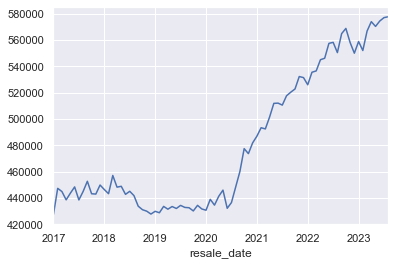

In [5]:
# Then we plot it

sns.set()
price_time.plot();

# It is quite visible that this time series data has trend
# However, we want to check its seasonality and residuals

## 3.1 Time Series Decomposition

In [6]:
# so next thing we do is to decompose the data into trend, seasonality, and residuals
# for now, we just use the classical decomposition

price_decomp = sm.tsa.seasonal_decompose(price_time, model = 'additive', extrapolate_trend=6) 

<Figure size 1080x720 with 0 Axes>

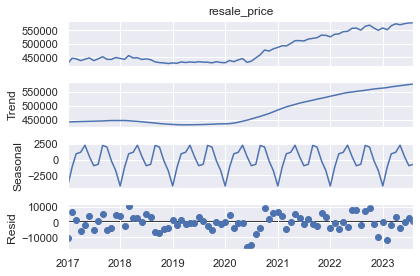

In [7]:
plt.figure(figsize = [15,10])
price_decomp.plot()
plt.savefig('decomposition.png');

In [8]:
price_trend = price_decomp.trend
price_season = price_decomp.seasonal
price_resid = price_decomp.resid

#### Trend

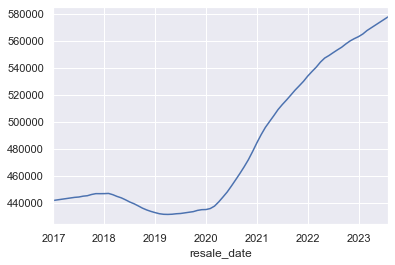

In [9]:
price_trend.plot();

# From the graph below, we can tell that our average monthly price
# has trend

In [10]:
%store price_trend

Stored 'price_trend' (Series)


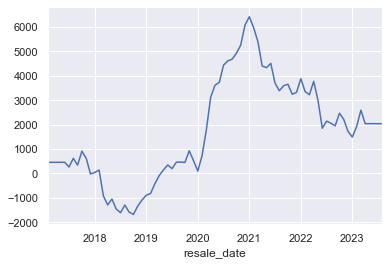

In [11]:
price_trend.diff(1).dropna().plot()

# In March 2018, the price started to drop  until April 2019
# and remained stable until Feb 2020
# March 2020 onwards, price start to spike
# After some searching, I found out that the price drop was caused my cooling measures
# Context: Cooling measure is a Singapore governments policy which purpose is to halt the increase of property prices

#### Seasonality

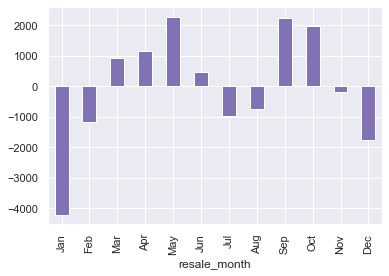

In [12]:
price_season_month = price_season.reset_index()
price_season_month['resale_month'] = price_season_month['resale_date'].dt.strftime('%b') # extract months information
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] #create months order

price_season_month['resale_month'] = pd.Categorical(price_season_month['resale_month'], categories= months_order, ordered = True)
pm = price_season_month.groupby('resale_month')['seasonal'].mean()
pm.plot(color = 'm', kind = 'bar')
plt.savefig('seasonality.png');

In [13]:
%store months_order

Stored 'months_order' (list)


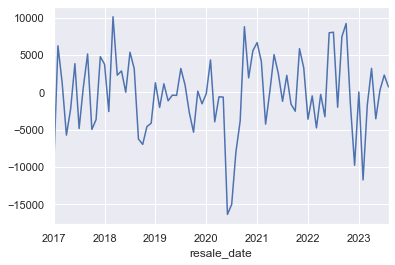

In [14]:
price_resid.plot();
# we can see that there is anomaly in mid-2020
# most likely caused by Covid-19 pandemic

## 3.2 Forecasting

In [15]:
price_time.index.freq = 'MS'

In [16]:
# we use log transformation because the model performs better this way

transform = np.log
reverse_transform = np.exp

In [17]:
price_time = price_time.apply(transform)

In [18]:
# Train-Test Split

price_train = price_time[:'Aug 2022']
price_test = price_time['Sep 2022':]

### 3.2.1 SARIMA method

from statsmodels.tsa.statespace.sarimax import SARIMAX
s = 12

for p in range(3, 4):
    for d in range(1, 2):
        for q in range(1, 4):
            for P in range(1, 4):
                for D in range(1, 2):
                    for Q in range(0, 4):
                        model = SARIMAX(price_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
                        results = model.fit()
                        print(f"ARIMA{p},{d},{q}-SARIMA{P},{D},{Q}-{s} - AIC: {results.aic}")


In [19]:
# From the grid search, we would like to choose a combination of parameters that results in as small as possible AIC score
# and a model that does not give us convergence warning
# So we pick this parameters: 

# ARIMA3,1,3-SARIMA1,1,3,12 - AIC: 11 -271.011

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p,d,q = 3,1,3
P,D,Q,s = 1,1,3,12
sarima_model = SARIMAX(price_train, order=(p, d, q), seasonal_order=(P, D, Q, s), suppress_warnings = True)
sarima_result = sarima_model.fit()

In [21]:
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       resale_price   No. Observations:                   68
Model:             SARIMAX(3, 1, 3)x(1, 1, 3, 12)   Log Likelihood                 146.505
Date:                            Wed, 25 Oct 2023   AIC                           -271.011
Time:                                    13:59:31   BIC                           -248.930
Sample:                                01-01-2017   HQIC                          -262.472
                                     - 08-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1901      0.678     -0.281      0.779      -1.518       1.138
ar.L2          0.2952      0.582      0.508      0.612      -0.845       1.435
ar.L3          0.0723      0.433      0.167      0.867      -0.776       0.921
ma.L1         -0.0756      0.651     -0.116      0.908      -1.352       1.201
ma.L2         -0.3370      0.525     -0.642      0.521      -1.366       0.692
ma.L3          0.2835      0.461      0.614      0.539      -0.621       1.188
ar.S.L12      -0.3309      1.940     -0.171      0.865      -4.133       3.471
ma.S.L12      -0.2081      1.774     -0.117      0.907      -3.685       3.268
ma.S.L24      -0.6053      1.565     -0.387      0.699      -3.672       2.461
ma.S.L36       0.1415      0.920      0.154      0.878      -1.661       1.944
sigma2         0.0002      0.000      1.493      0.135   -7.03e-05       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.41
Prob(Q):                              0.87   Prob(JB):                         0.02
Heteroskedasticity (H):               0.67   Skew:                             0.26
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

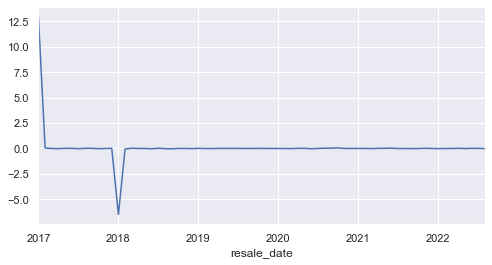

In [22]:
plt.figure(figsize=[8,4])
sarima_result.resid.plot()
plt.savefig('residual.png');

# for some reasons the residual values at 1st and 13th index are always extremely large
# no matter how I change the model's parameters
# but the rest are just normal

In [23]:
sarima_result.resid[13:].mean()

0.0012926094065157656

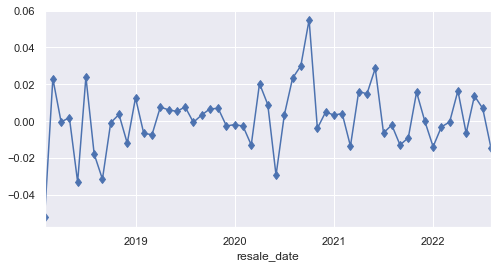

In [24]:
plt.figure(figsize=[8,4])
sarima_result.resid[13:].plot(marker = 'd')
plt.savefig('residual-no outlier.png');

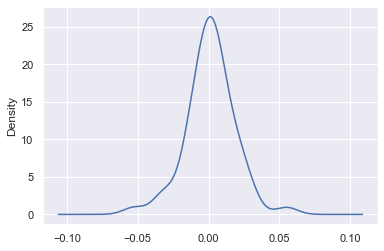

In [25]:
sarima_result.resid[13:].plot(kind = 'kde');

In [26]:
train_predict = sarima_result.predict() 
test_predict = sarima_result.forecast(steps = len(price_test))

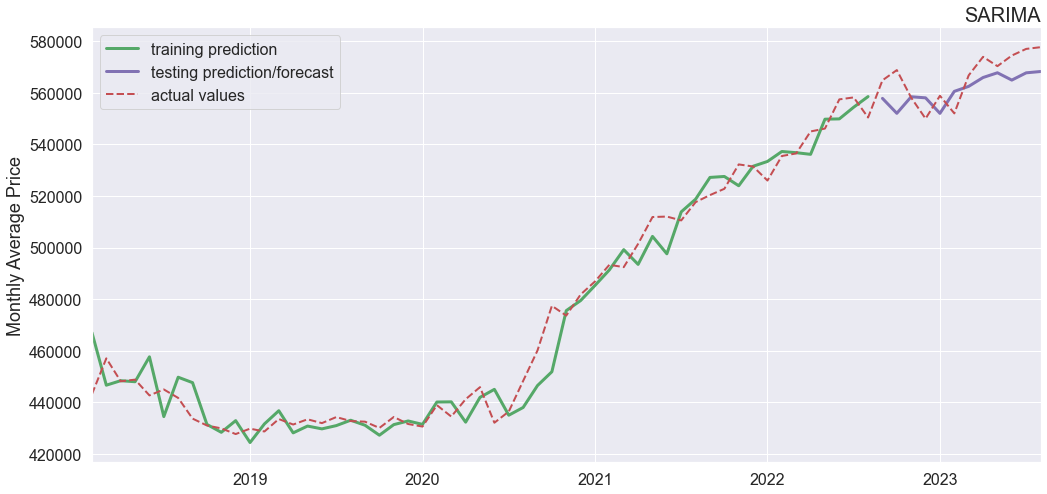

In [39]:
# do not forget to reverse our data's log transformation

fontsize1 = 20
fontsize2 = 16

plt.figure(figsize=[17,8])
train_predict[13:].apply(reverse_transform).plot(label = "training prediction", linewidth = 3, color = 'g')
test_predict.apply(reverse_transform).plot(label = "testing prediction/forecast", linewidth = 3, color = 'm')
price_time[13:].apply(reverse_transform).plot(linestyle = '--', label = "actual values", linewidth = 2, color = 'r')

plt.legend(fontsize = fontsize2)
plt.title('SARIMA', fontsize = fontsize1, loc = 'right')

plt.xlabel('', fontsize = fontsize2)
plt.ylabel('Monthly Average Price', fontsize = fontsize2+2)

plt.xticks(fontsize = fontsize2)
plt.yticks(fontsize = fontsize2)

plt.savefig('model evaluation.png');

In [28]:
from sklearn.metrics import mean_absolute_error as MAE

MAE_train = MAE(price_train[13:].apply(reverse_transform),train_predict[13:].apply(reverse_transform))
MAE_test = MAE(price_test.apply(reverse_transform),test_predict.apply(reverse_transform))
delta_MAE = abs(MAE_train - MAE_test)/MAE_train *100

In [29]:
print(f'Monthly Average Price = {price_time.apply(reverse_transform).mean():.2f}')
print(f'MAE of training dataset = {MAE_train:.2f}')
print(f'MAE of testing dataset = {MAE_test:.2f}')
print(f'MAE change = {delta_MAE:.2f}%')

Monthly Average Price = 481070.15
MAE of training dataset = 5748.89
MAE of testing dataset = 7549.98
MAE change = 31.33%


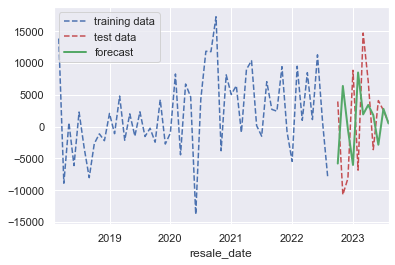

In [30]:
# forecast.apply(reverse_transform).diff().plot(label = 'forecast', linewidth = 2)
price_train[13:].apply(reverse_transform).diff().plot(label = 'training data', linestyle = '--')
price_test.apply(reverse_transform).diff().plot(color = 'r', linestyle = '--', label = 'test data')
test_predict.apply(reverse_transform).diff().plot(color = 'g', linewidth = 2, label = 'forecast')
plt.legend();

In [31]:
%store sarima_result

Stored 'sarima_result' (SARIMAXResultsWrapper)


### 3.2.2 Holt-Winters method

In [32]:
# let's see how other forecasting technique works for our data

from statsmodels.tsa.holtwinters import ExponentialSmoothing

HW_model = ExponentialSmoothing(price_train, seasonal='add', seasonal_periods= 12)  # 'add' for additive seasonality
HW_result = HW_model.fit()

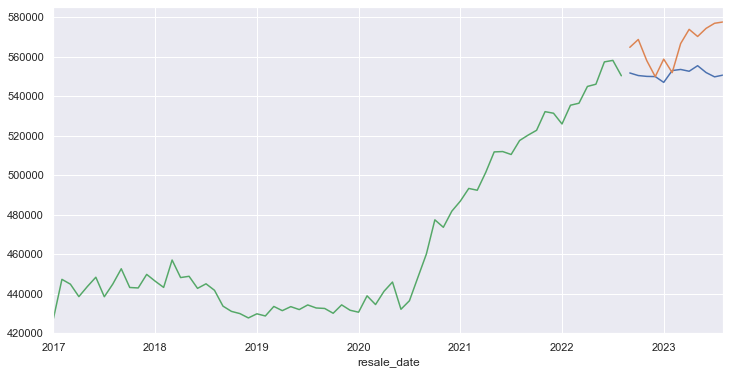

In [33]:
plt.figure(figsize= [12,6])
HW_result.forecast(len(price_test)).apply(reverse_transform).plot()
price_test.apply(reverse_transform).plot()
price_train.apply(reverse_transform).plot();

# Holt-Winters does not work well for our dataset
# nah!